In [15]:
import os
import cv2
import numpy as np
from tqdm import tqdm 
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
REBUILD_DATA = False

In [14]:
class DogsVSCats():
    IMG_SIZE = 50
    CATS = "data/PetImages/Cat"
    DOGS = "data/PetImages/Dog"
    LABELS = {CATS:0,DOGS:1}
    
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_traning_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE,self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                    
                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
                    #print(str(e))
                    
        np.random.shuffle(self.training_data)
        np.save("training_data.npy",self.training_data)
        print("cats:",self.catcount)
        print("dogs",self.dogcount)
    
if REBUILD_DATA:
    dogsvscats = DogsVSCats()
    dogsvscats.make_traning_data()

  0%|                                      | 13/12501 [00:00<01:37, 127.59it/s]

data/PetImages/Cat


  0%|                                      | 15/12501 [00:00<01:27, 142.40it/s]

data/PetImages/Dog


100%|███████████████████████████████████| 12501/12501 [01:22<00:00, 151.22it/s]


cats: 12476
dogs 12470


In [2]:
training_data = np.load("training_data.npy",allow_pickle=True)

In [3]:
print(len(training_data))

24946


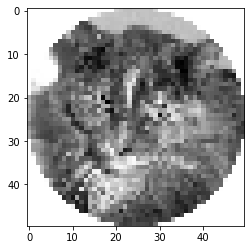

In [8]:
plt.imshow(training_data[1][0],cmap="gray")
plt.show()

In [9]:
training_data[1][1]

array([1., 0.])

In [30]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,5)
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)
        
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512,2)
        
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))    
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        
        #print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1,self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim = 1)

net = Net()
        

In [23]:
optimizer = optim.Adam(net.parameters(),lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [24]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [31]:
BATCH_SIZE = 100
EPOCHS = 1
for epoch in range(EPOCHS):
    for i in tqdm(range(0,len(train_X),BATCH_SIZE)):
        #print(i,i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        net.zero_grad()
        outputs =  net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

print(loss)

100%|████████████████████████████████████████| 225/225 [02:19<00:00,  1.61it/s]

tensor(0.2491, grad_fn=<MseLossBackward>)


In [32]:
correct = 0
total = 0
with torch.no_grad():
        for i in tqdm(range(len(test_y))):
            real_class = torch.argmax(test_y[i])
            net_out = net(test_X[i].view(-1,1,50,50))[0]
            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct += 1
            total +=1

print("Accuracy:",round(correct/total,3))

100%|█████████████████████████████████████| 2494/2494 [00:20<00:00, 121.89it/s]

Accuracy: 0.499
